# Assignment 2c Notebook: Competitive Co-Evolution of Pac-Man Controllers and Maps
For the final assignment in this course, you will use your cumulative understanding and implementation of evolutionary algorithms (EA) and genetic programming (GP) to implement the competitive co-evolution of Pac-Man controllers and maps! From your previous assignment implementations, copy over the following files:
* baseEvolution.py
* binaryGenotype.py
* fitness.py
* geneticProgramming.py (Note: we recommend renaming geneticProgrammingPopulating -> geneticProgrammingPopulation)
* selection.py
* treeGenotype.py

As usual, be careful not to overwrite any of the provided files that may have been modified since previous assignments. To begin the assignment, execute the following cell. **If you implemented your genotype in a new file, be sure to import it in the next cell!**

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from snakeeyes import readConfig
from fitness import play_GPac
from selection import *
from baseEvolution import baseEvolutionPopulation
from binaryGenotype import binaryGenotype
from geneticProgramming import *
from treeGenotype import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('The first cell has been executed!')

The first cell has been executed!


## Multi-Population Fitness Evaluation
Assuming you already have working implementations of an EA for maps and a GP algorithm for Pac-Man controllers, we can begin by discussing competitive fitness evaluations. Competitive fitness in GPac has the quirk of only being relative to encountered opponents. Since opponents belong to populations that are evolving, we must re-calculate fitness for all individuals at each generation. Additionally, since it is impracticable to play against all opponents, it is necessary to *approximate* fitness in some way. In practice, you would approximate fitness of an individual through competition with a sample of opponents. In this assignment, however, we allow for each individual to play against only a single opponent per generation to manage computational cost.

**Note**: as mentioned in the assignment description, an individual from a population may have to play multiple games if co-evolving populations are not the same size. See the assignment description for more details.

As a result of the complex nature of competitive fitness for games like GPac, you will typically perform more fitness evaluations per generation than evolution using the same parameters on a problem with an objective/absolute fitness metric. For this assignment, the first generation will require $max(\mu_{PacMan}, \mu_{map})$ fitness evaluations and each subsequent generation will require $max(\mu_{PacMan}+\lambda_{PacMan}, \mu_{map}+\lambda_{map})$ fitness evaluations.

In the following cell, implement a `competitive_evaluation` function that accepts multiple populations as inputs, forms competition match-ups of individuals from the input populations, performs fitness evaluations with the match-ups, and assigns the appropriate fitness values to individuals from the input populations. Note that the `play_GPac` function returns game score and this will need to be negated for map fitness. Recall also that GP trees should receive a parsimony penalty.

In [2]:
from random import shuffle
from statistics import mean
def competitive_evaluation(pac_population, map_population, penalty_coefficient, opponentCount = 1, **fitness_kwargs):
    #I know this is a stupid way of assigning matches, but its kind of random, and I don't know how to guarantee everyone plays once with the sample function
    
    matches = []
    shuffle(map_population)
    shuffle(pac_population)
    for i in range(opponentCount):
        if(len(map_population) < len(pac_population)):
            for map_individual_idx in range(len(map_population)):
                matches.append({"Map" : map_population[map_individual_idx], "Pac" : pac_population[(map_individual_idx + i) % len(pac_population)]})
                map_population[map_individual_idx].fitsFromCompetition = []
        else:
            for pac_individual_idx in range(len(pac_population)):
                matches.append({"Map" : map_population[(pac_individual_idx + i)% len(map_population)], "Pac" : pac_population[pac_individual_idx]})
                pac_population[pac_individual_idx].fitsFromCompetition = []
                pac_population[pac_individual_idx].rawFitsFromCompetition = []

    # TODO: evaluate matches with play_GPac
    # Hint: play_GPac(pac_controller, map_gene, **fitness_kwargs)
    for match in matches:
        fitness, log = play_GPac(match["Pac"].gene, match["Map"].gene, **fitness_kwargs)
        #if there are less maps than pacs, each map will have multiple pacs
        if(len(map_population) < len(pac_population)) or opponentCount > 1:
            match["Map"].fitsFromCompetition.append(-fitness)
            if(-fitness == min(match["Map"].fitsFromCompetition)):
                match["Map"].log = log
        else:
            match["Map"].fitness = -fitness
            match["Map"].log = log
        match["Pac"].gene.updateChildrenCount(match["Pac"].gene.root)
        #if there are more pacs than maps each pac will have multiple maps
        if(len(map_population) > len(pac_population or opponentCount > 1)):
            match["Pac"].rawFitsFromCompetition.append( fitness)
            match["Pac"].fitsFromCompetition.append(fitness - penalty_coefficient * (match["Pac"].gene.root.childrenCount+1))
            if(fitness == max(match['Pac'].rawFitsFromCompetition)):
                match["Pac"].log = log
        else:
            match["Pac"].rawFitness = fitness
            match["Pac"].fitness = match["Pac"].rawFitness - penalty_coefficient * (match["Pac"].gene.root.childrenCount+1)    
            match["Pac"].log = log
    if(len(map_population) < len(pac_population) or opponentCount > 1):
        for map_individual in map_population:
            map_individual.fitness = mean(map_individual.fitsFromCompetition)
    elif(len(map_population) > len(pac_population) or opponentCount > 1):
        for pac_individual in pac_population:
            pac_individual.fitness = mean(pac_individual.fitsFromCompetition)
            pac_individual.rawFitness = mean(pac_individual.fitsFromCompetition)
    # TODO: calculate and assign fitness (don't forget the parsimony penalty)
    pass

In [3]:
import statistics
config = readConfig('./configs/green2c_config.txt', globalVars=globals(), localVars=locals())
b = binaryGenotype()
treePopulation = treeGenotype.initialization(25, **config['pac_initialization_kwargs'])
mapPopulation = binaryGenotype.initialization(25, **config['map_initialization_kwargs'])

competitive_evaluation(treePopulation, mapPopulation, **config['fitness_kwargs'])

# inspect fitness assignment
print(f'Trees with unassigned fitness: {len([individual.fitness for individual in treePopulation if individual.fitness is None])}')
print(f'Maps with unassigned fitness: {len([individual.fitness for individual in mapPopulation if individual.fitness is None])}')

# inspect per-species fitness values
print(f'Average fitness of tree population: {statistics.mean([individual.fitness for individual in treePopulation])}')
maxFitness = max([individual.fitness for individual in treePopulation])
print(f'Best fitness in tree population: {maxFitness}')
print(f'Average fitness of map population: {statistics.mean([individual.fitness for individual in mapPopulation])}')
maxFitness = max([individual.fitness for individual in mapPopulation])
print(f'Best fitness in map population: {maxFitness}')

del config
del treePopulation
del mapPopulation

Trees with unassigned fitness: 0
Maps with unassigned fitness: 0
Average fitness of tree population: -3.3040000000000003
Best fitness in tree population: 9.8
Average fitness of map population: -2.56
Best fitness in map population: 0


## Competitive Co-Evolution
Below is a high-level diagram of a 2-population competitive co-evolutionary algorithm. Using your implementations of map evolution from Assignment Series 1, Pac-Man controller evolution from Assignment 2b, and the `competitive_evaluation` function you just implemented, you should have all the necessary components to implement competitive co-evolution!
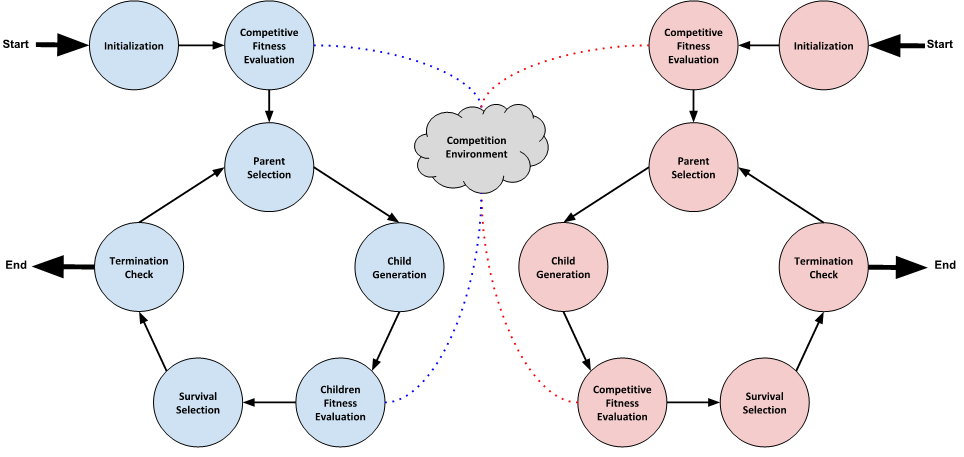

As mentioned previously, the quirks of competitive fitness require that you modify your typical evolution cycles slightly. Namely, you must re-evaluate and recalculate fitness for both populations at each generation. This means that children will be added to the population following child generation and then the entire population should be evaluated. Consequently, the number of fitness evaluations per generation varies from previous assignments.

### Single Run Experiment
Now that we've covered the quirks of co-evolution a couple times, it's time for you to apply your understanding! In the following cell, implement a single 2,000-fitness-evaluation run of your competitive co-evolutionary algorithm. The config file for co-evolution is a little more complex than previous assignments, so we'll give some code to extract per-species parameters.

In [4]:
number_evaluations = 2000
from math import inf

# You can parse different configuration files here as necessary
config = readConfig('./configs/green2c_config.txt', globalVars=globals(), localVars=locals())
def competitiveEvolution(config, number_evaluations, runNumber):
    pac_config = {key.partition('_')[-1]:config[key] for key in config if "pac_" in key}
    map_config = {key.partition('_')[-1]:config[key] for key in config if "map_" in key}
    pac_population = geneticProgrammingPopulation(**config['pac_GP_configs'], **pac_config)
    map_population = baseEvolutionPopulation(**config['map_EA_configs'], **map_config)
    competitive_evaluation(pac_population.population,map_population.population, **config['fitness_kwargs'])
    pac_population.evaluations = len(pac_population.population)
    map_population.evaluations = len(map_population.population)
    avg_pac_fitnesses = [statistics.mean([individual.rawFitness for individual in pac_population.population])]
    avg_map_fitnesses = [statistics.mean([individual.fitness for individual in map_population.population])]
    max_map_fitnesses = [max([individual.fitness for individual in map_population.population])]
    max_pac_fitnesses = [max([individual.rawFitness for individual in pac_population.population])]
    evals = max([len(pac_population.population), len(map_population.population)])
    evals_at_iteration = [evals]
    while(evals < number_evaluations):
        competitive_evaluation(pac_population.population,map_population.population, **config['fitness_kwargs'])
        pac_children = pac_population.generate_children()
        pac_population.population += pac_children
        map_children = map_population.generate_children()
        map_population.population += map_children
        competitive_evaluation(pac_population.population,map_population.population, **config['fitness_kwargs'])
        evals += max([len(map_population.population), len(pac_population.population)])
        map_population.survival()
        pac_population.survival()
        avg_pac_fitnesses.append(statistics.mean([individual.rawFitness for individual in pac_population.population]))
        avg_map_fitnesses.append(statistics.mean([individual.fitness for individual in map_population.population]))
        max_map_fitnesses.append(max([individual.fitness for individual in map_population.population]))
        max_pac_fitnesses.append(max([individual.rawFitness for individual in pac_population.population]))
        evals_at_iteration.append(evals)
    pac_max_fit = -inf
    map_max_fit = -inf
    best_pac = None
    best_map = None
    for pac_individual in pac_population.population:
        if(pac_individual.rawFitness > pac_max_fit):
            best_pac = pac_individual
            pac_max_fit = best_pac.rawFitness
    for map_individual in map_population.population:
        if(map_individual.rawFitness > map_max_fit):
            best_map = map_individual
            map_max_fit = best_map.fitness
    return {"best_pac_from_final_gen" : best_pac, "best_map_from_final_gen" : best_map, 'avg_map_fitnesses': avg_map_fitnesses, "avg_pac_fitnesses" : avg_pac_fitnesses, "max_map_fitnesses": max_map_fitnesses, "max_pac_fitnesses": max_pac_fitnesses, "evals_at_iteration" : evals_at_iteration }
    

### Multi-Run Experiment
Implement a full 30-run experiment with 2,000 fitness evaluations per run. For each generation, log the average fitness and best fitness of the current population for each species. Average this data across all 30 runs to produce a plot of fitness vs evaluations with average and best fitness averaged across all 30 runs. For each run, log the best fitness of the final population for each species. For the run that produced the highest score in the final generation, play an exhibition game between the highest-fitness Pac-Man controller and map from the same run and generation. Save the log from this exhibition game and visualize it for informal analysis in your report. For more detail on report requirements, see the assignment description.

In [5]:
number_runs = 30
number_evaluations = 2000
from multiprocessing import Pool
from functools import partial
# You can parse different configuration files here as necessary
config = readConfig('./configs/green2c_config.txt', globalVars=globals(), localVars=locals())
pac_config = {key.partition('_')[-1]:config[key] for key in config if "pac_" in key}
map_config = {key.partition('_')[-1]:config[key] for key in config if "map_" in key}
if __name__ == '__main__':
    p = Pool(number_runs)
    partialEa = partial(competitiveEvolution, config, number_evaluations)
    solutions = p.map(partialEa, range(number_runs))
    p.close()
    p.join()
# Implement your 30-run experiment here


In [6]:
best_pac = None
best_map = None
pac_max_fit = -inf
for solution in solutions:
    if(pac_max_fit < solution["best_pac_from_final_gen"].rawFitness):
        best_pac = solution['best_pac_from_final_gen']
        best_map = solution['best_map_from_final_gen']
fitness, log = play_GPac(best_pac.gene, best_map.gene, **config['fitness_kwargs'])

game_log_path = 'worldFiles/exhibition_log.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in log]

In [7]:
avg_map_fits = [solution['avg_map_fitnesses'] for solution in solutions]
mean_avg_map_fits = list(map(statistics.mean, zip(*avg_map_fits)))
max_map_fits = [solution['max_map_fitnesses'] for solution in solutions]
avg_max_map_fits = list(map(statistics.mean, zip(*max_map_fits)))

avg_pac_fits = [solution['avg_pac_fitnesses'] for solution in solutions]
mean_avg_pac_fits = list(map(statistics.mean, zip(*avg_pac_fits)))
max_pac_fits = [solution['max_pac_fitnesses'] for solution in solutions]
avg_max_pac_fits = list(map(statistics.mean, zip(*max_pac_fits)))

In [55]:
evalList = [evals for evals in solutions[0]['evals_at_iteration']]
plt.plot(evalList, mean_avg_map_fits)

plt.title("Mean Average Map Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Average Map Fitness')
plt.savefig('data/green/meanAvgMapFitGraph.jpg')
plt.show()

In [56]:
plt.plot(evalList, avg_max_map_fits)

plt.title("Mean Max Map Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Mean Max Map Fitness')
plt.savefig('data/green/meanMaxMapFitGraph.jpg')
plt.show()

In [57]:
plt.plot(evalList, mean_avg_pac_fits)

plt.title("Mean Average Pac Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Average Pac Fitness')
plt.savefig('data/green/meanAvgPacFitGraph.jpg')
plt.show()

In [58]:
plt.plot(evalList, avg_max_pac_fits)

plt.title("Mean Max Pac Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Mean Max Pac Fitness')
plt.savefig('data/green/meanMaxPacFitGraph.jpg')
plt.show()

In [59]:
treePath = 'solutions/bestParseTree.txt'
with open(treePath, 'w') as f:
    f.write(str(best_pac.gene))
treePath = 'solutions/bestBinaryString.txt'
with open(treePath, 'w') as f:
    f.write(str(best_map.gene))

In [60]:
with open("data/green/maxRawPacFitsVMap.txt", 'w') as f:
    [f.write(str(solution['best_pac_from_final_gen'].rawFitness) + '\n') for solution in solutions]
with open("data/green/maxRawMapFitsVPac.txt", 'w') as f:
    [f.write(str(solution['best_map_from_final_gen'].rawFitness) + '\n') for solution in solutions]


In [39]:
def plotMap(maze, mazeNumber):
    '''A so-so map plotting function'''
    print(range(len(maze)))
    pltmaze = [[None for __ in range(len(maze))] for _ in range(len(maze[0]))]
    for y in range(len(maze[0])):
        for x in range(len(maze)):
            pltmaze[y][x] = 0 if maze[x][y]==1 else 1
    plt.matshow(pltmaze, origin='lower')
    plt.xticks(range(len(pltmaze[0])))
    plt.yticks(range(len(pltmaze)))
    plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
    plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
    plt.grid(which='minor')
    plt.savefig('data/maps/bestMapFromRun' + str(mazeNumber) + '.jpg')
    plt.show()

range(0, 35)


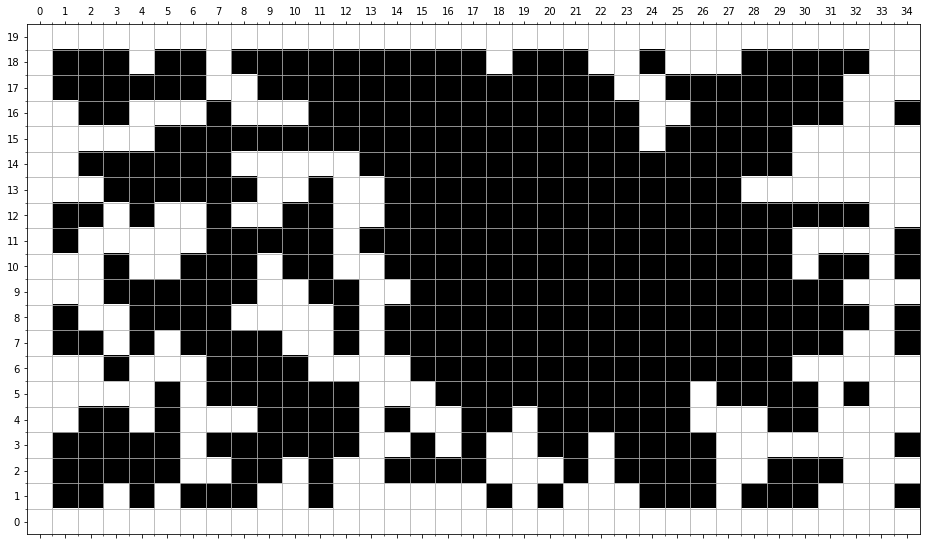

range(0, 35)


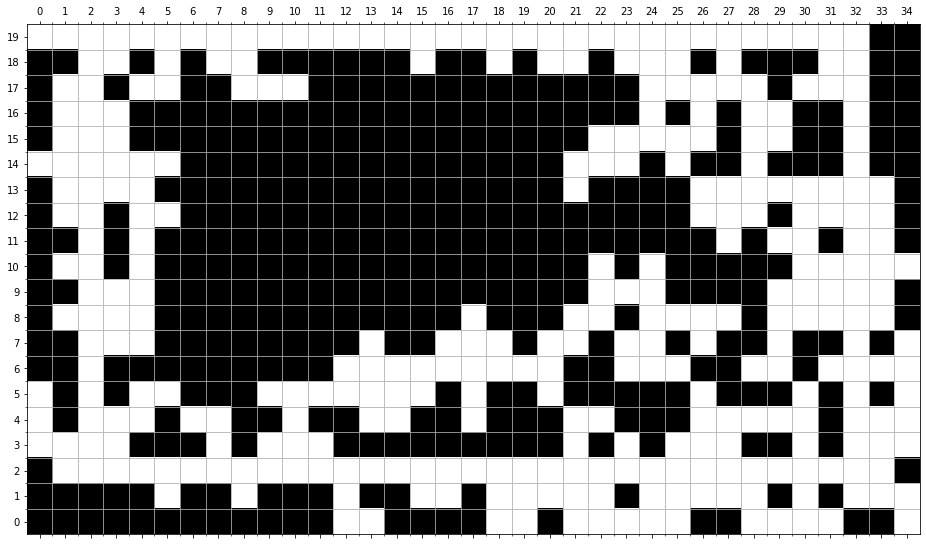

range(0, 35)


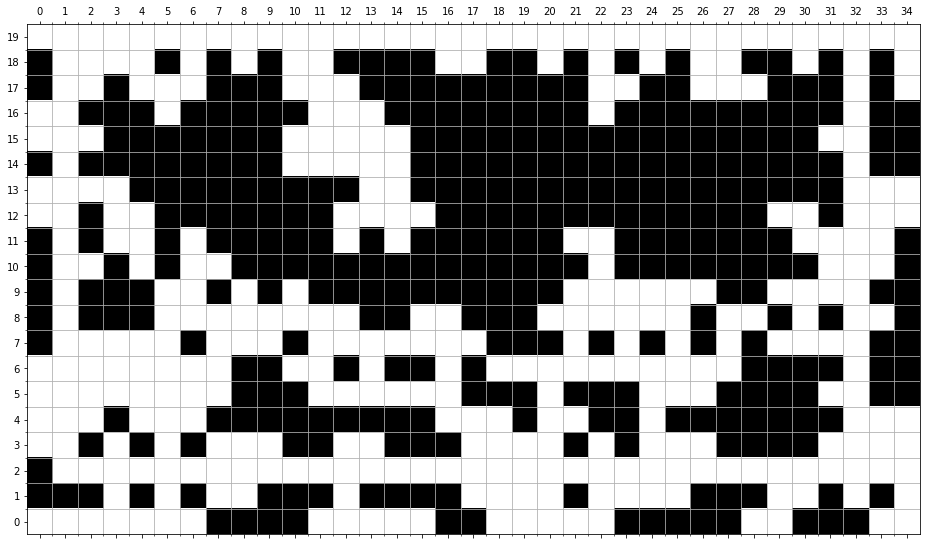

range(0, 35)


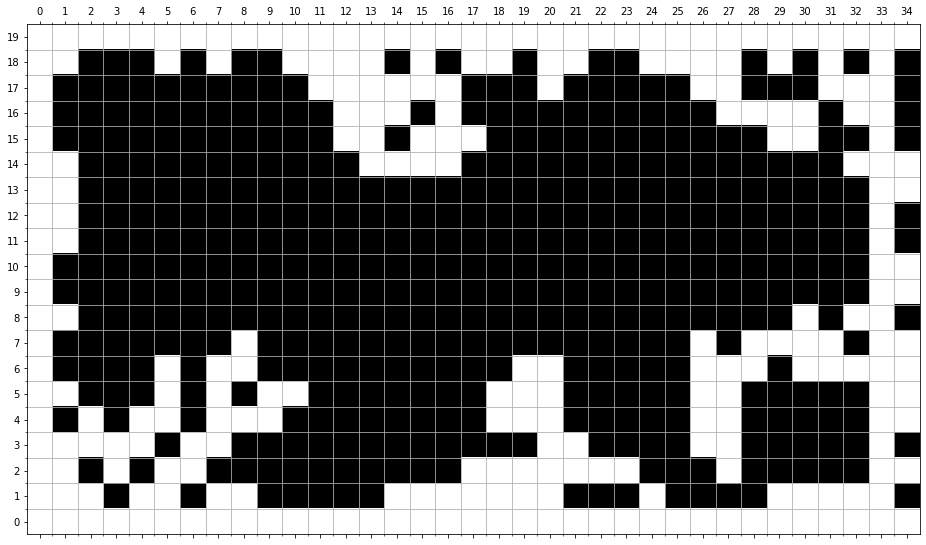

range(0, 35)


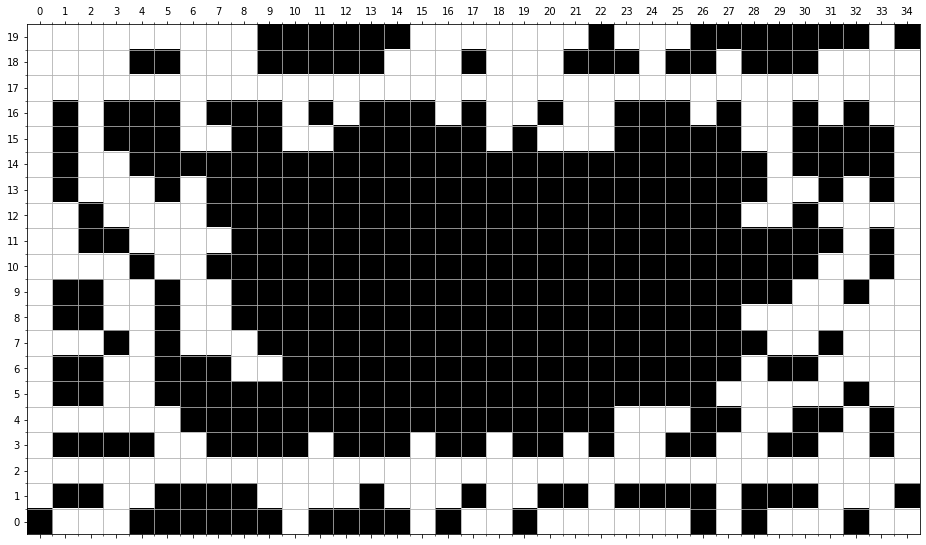

range(0, 35)


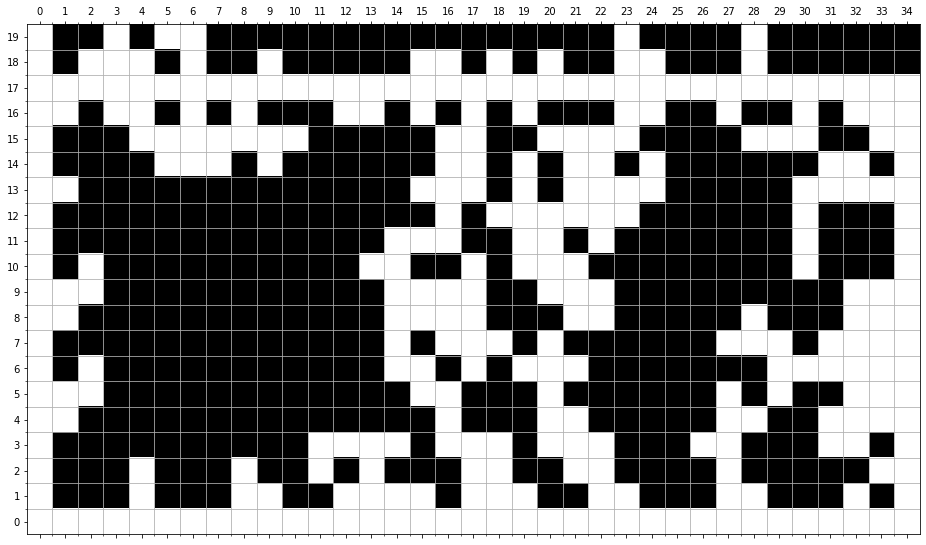

range(0, 35)


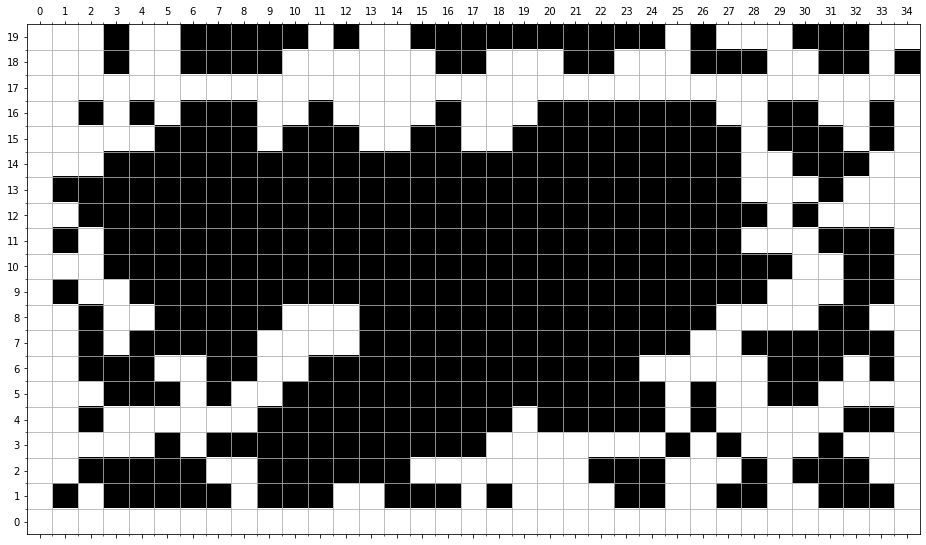

range(0, 35)


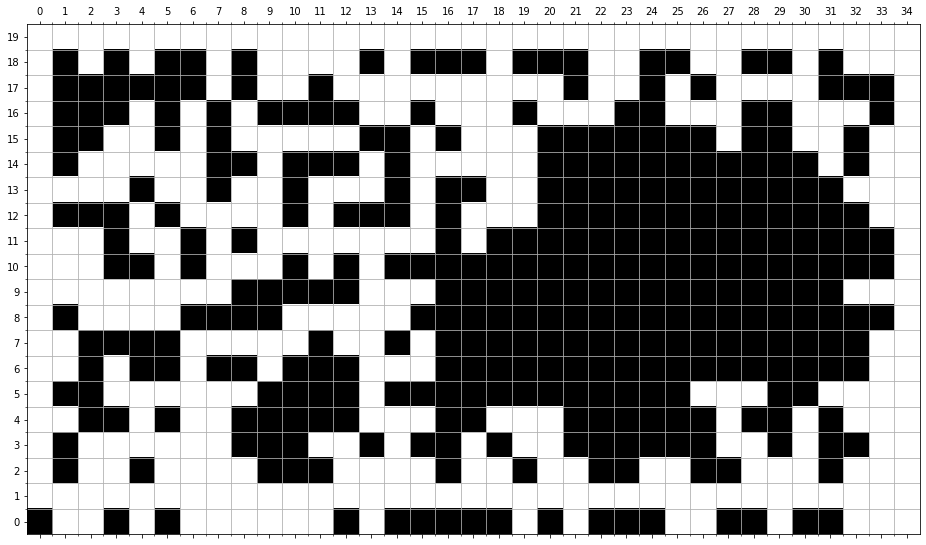

range(0, 35)


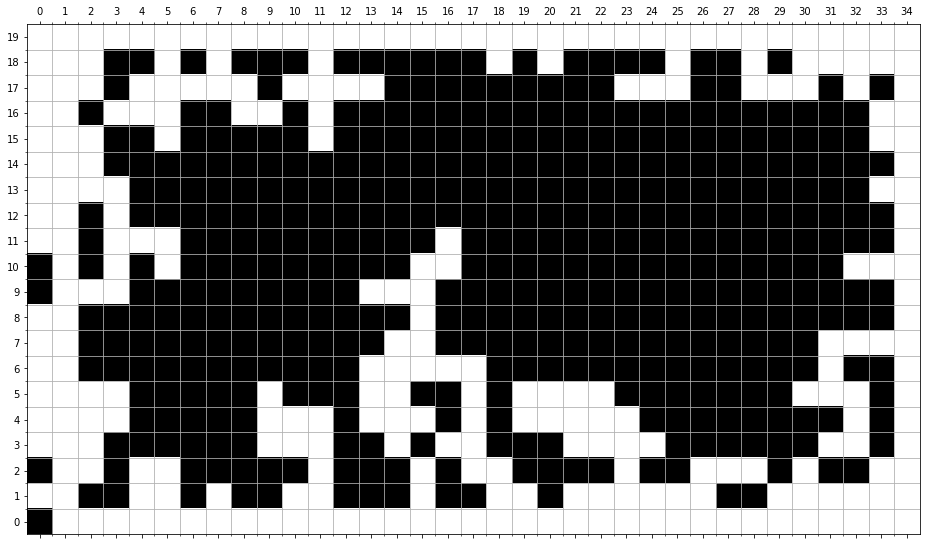

range(0, 35)


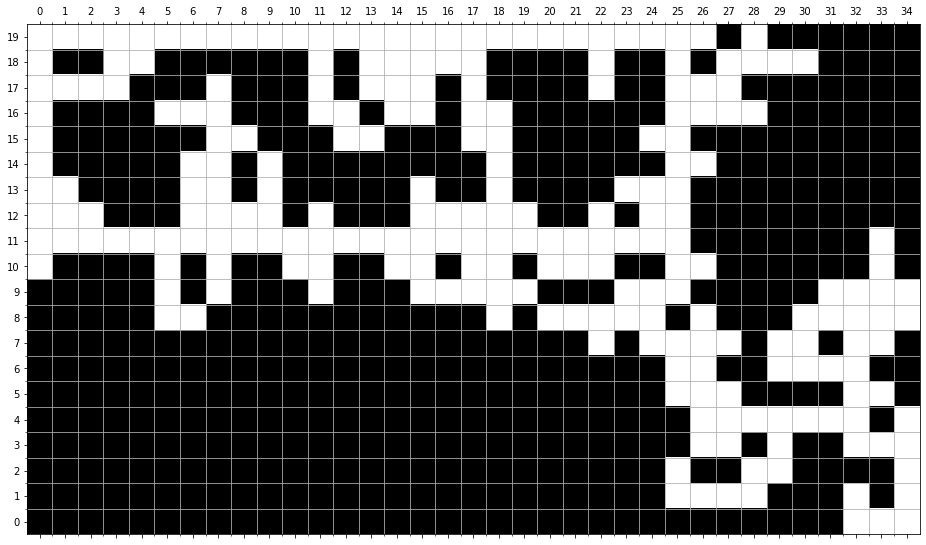

range(0, 35)


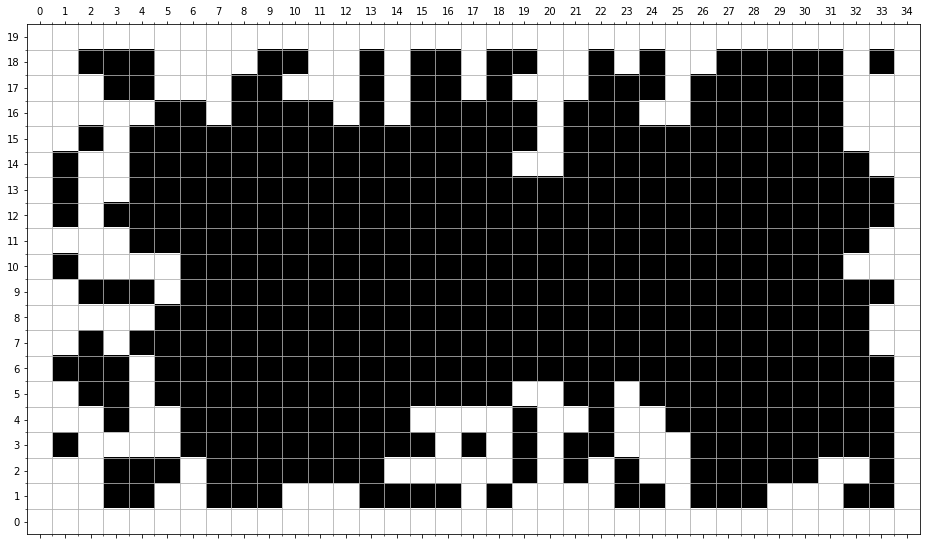

range(0, 35)


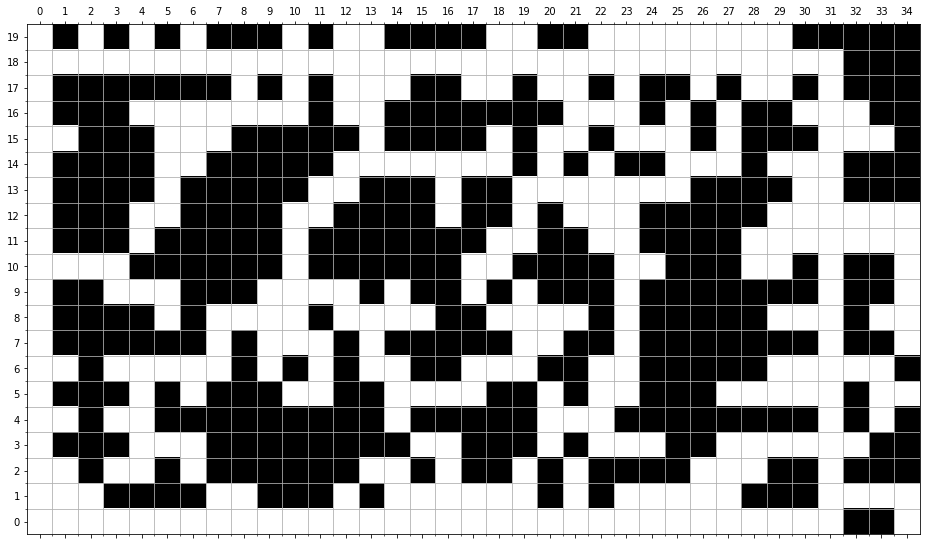

range(0, 35)


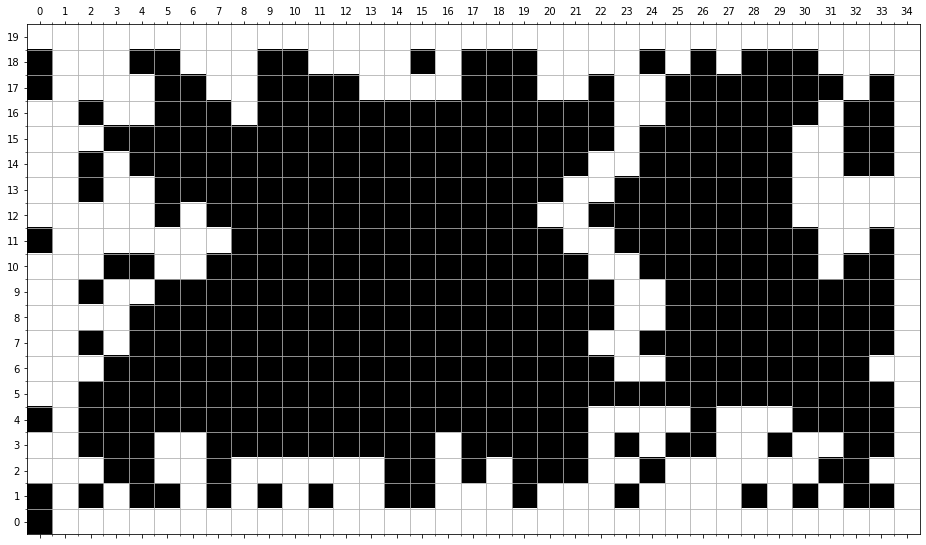

range(0, 35)


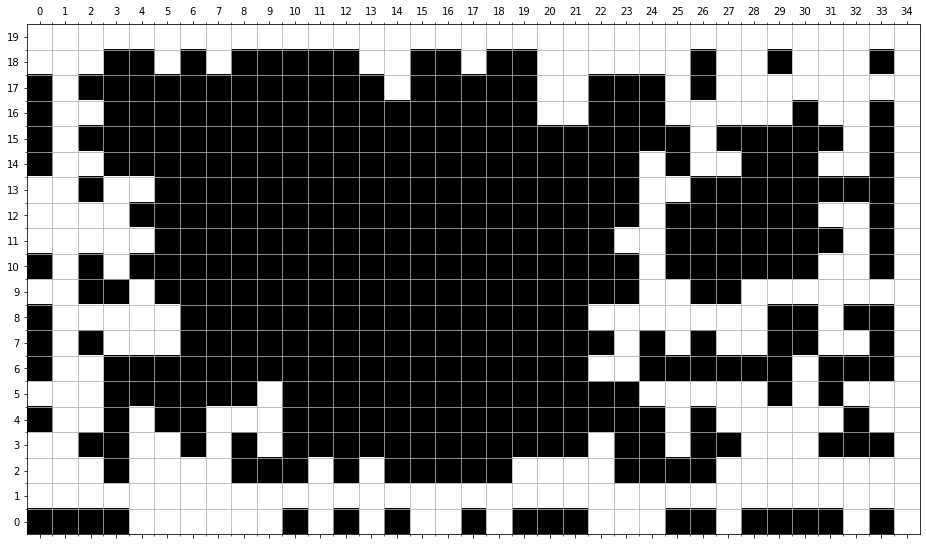

range(0, 35)


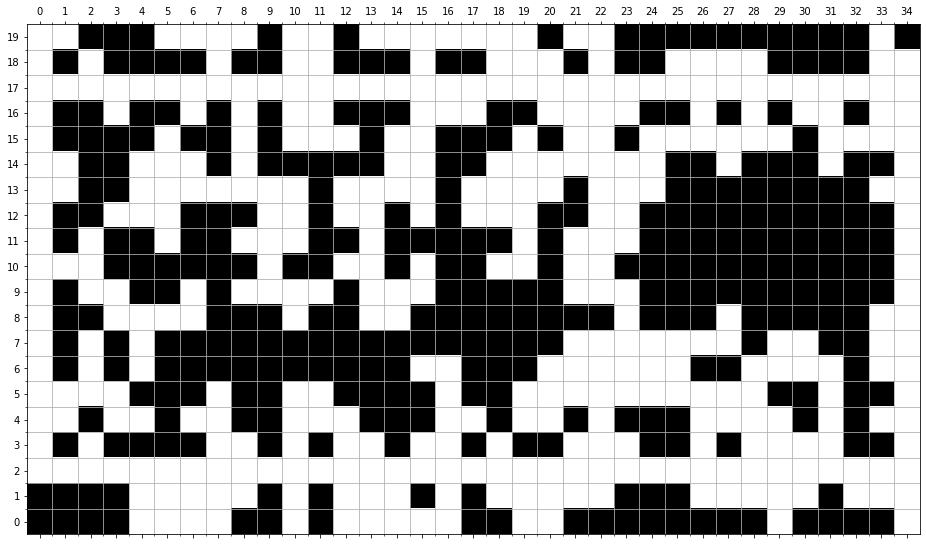

range(0, 35)


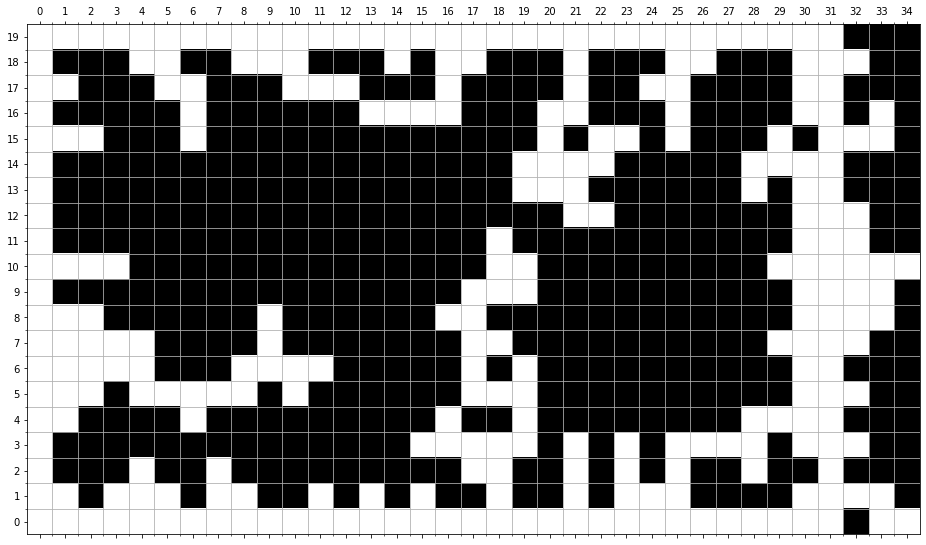

range(0, 35)


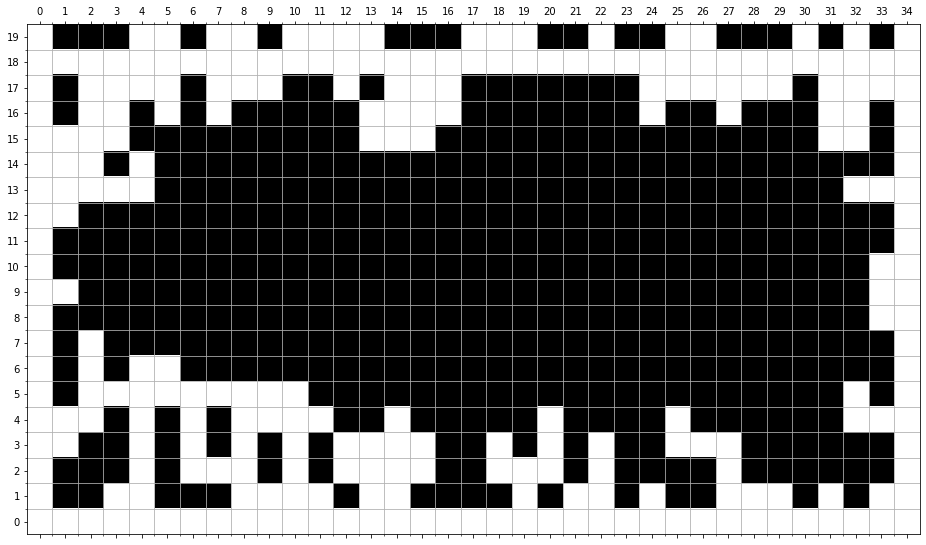

range(0, 35)


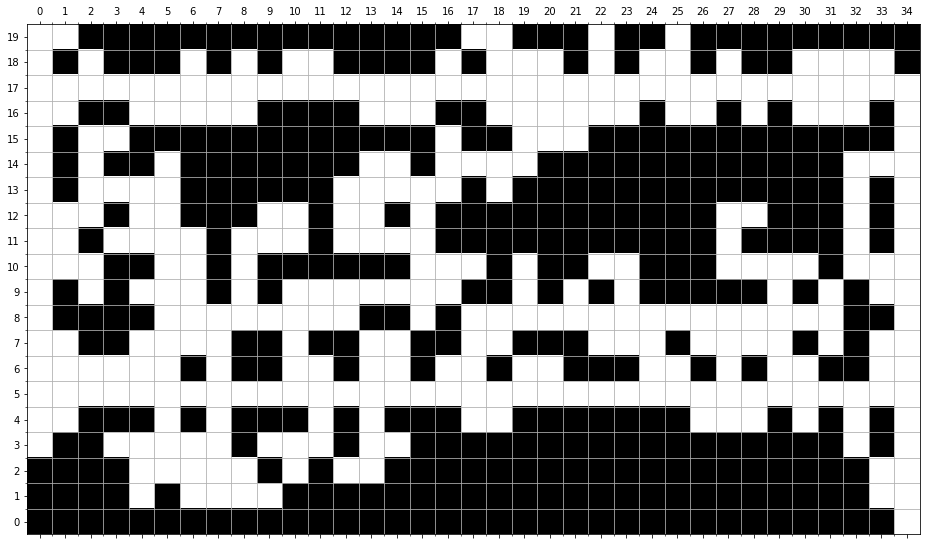

range(0, 35)


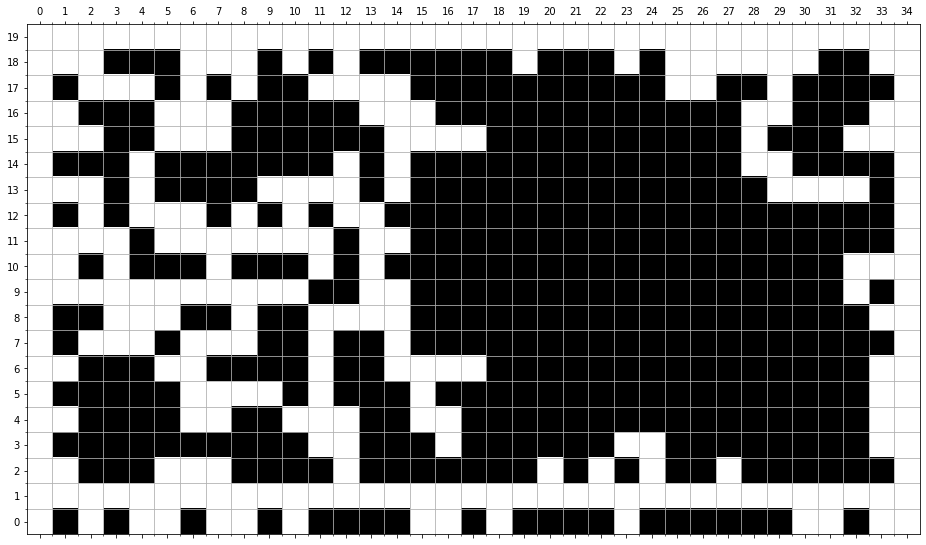

range(0, 35)


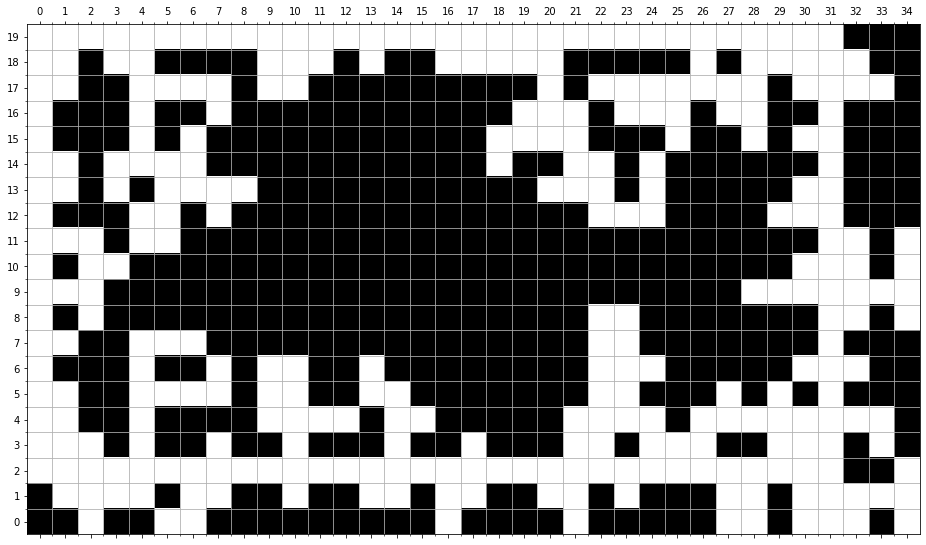

range(0, 35)


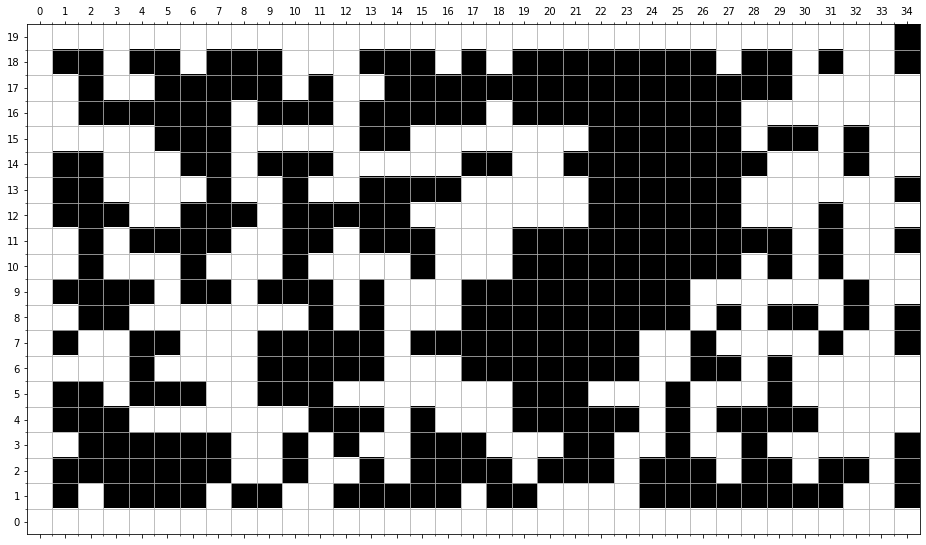

range(0, 35)


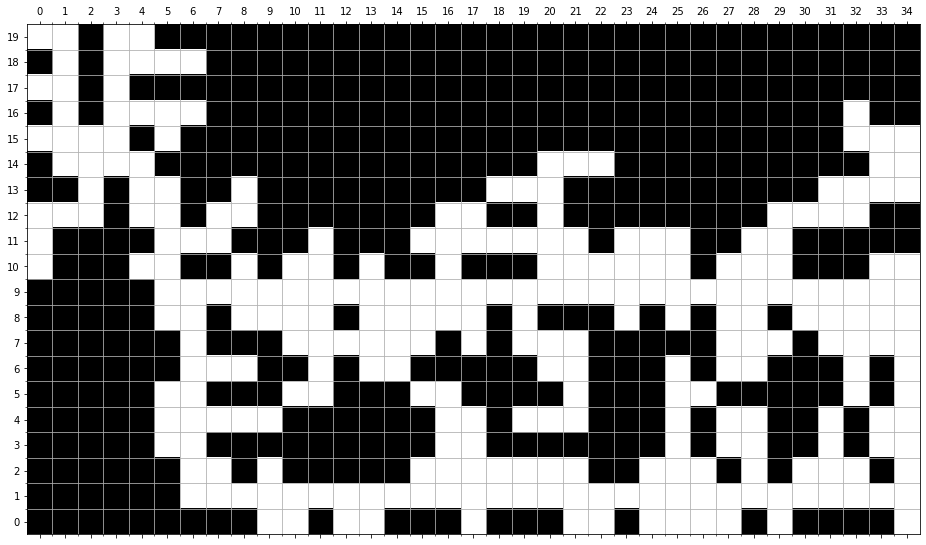

range(0, 35)


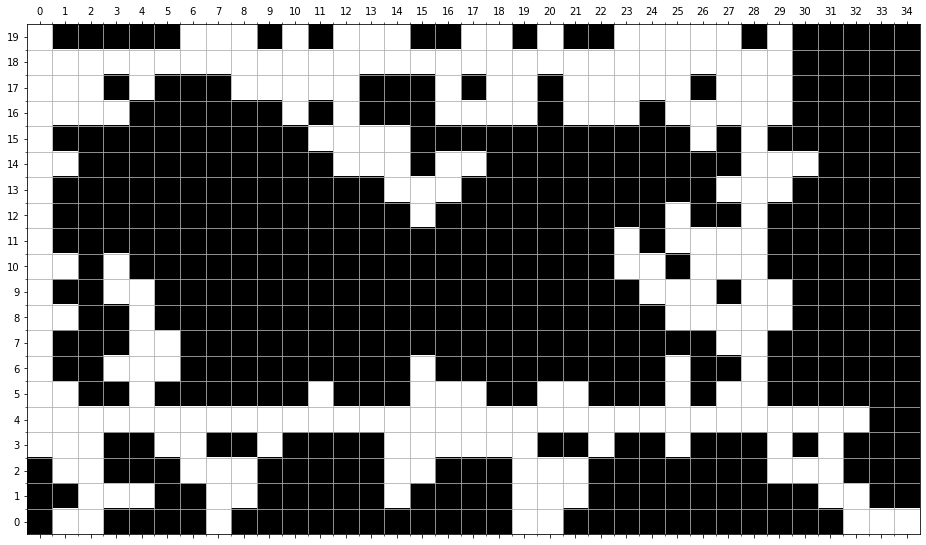

range(0, 35)


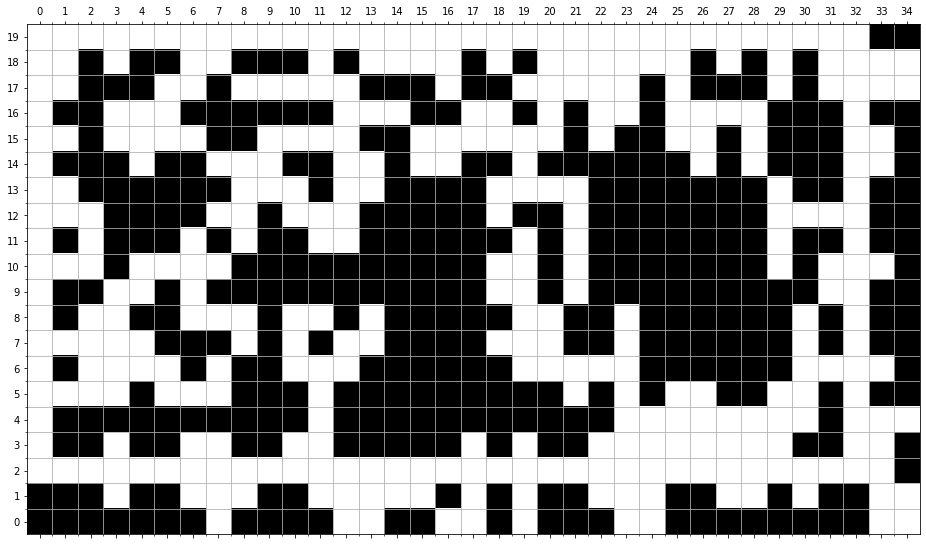

range(0, 35)


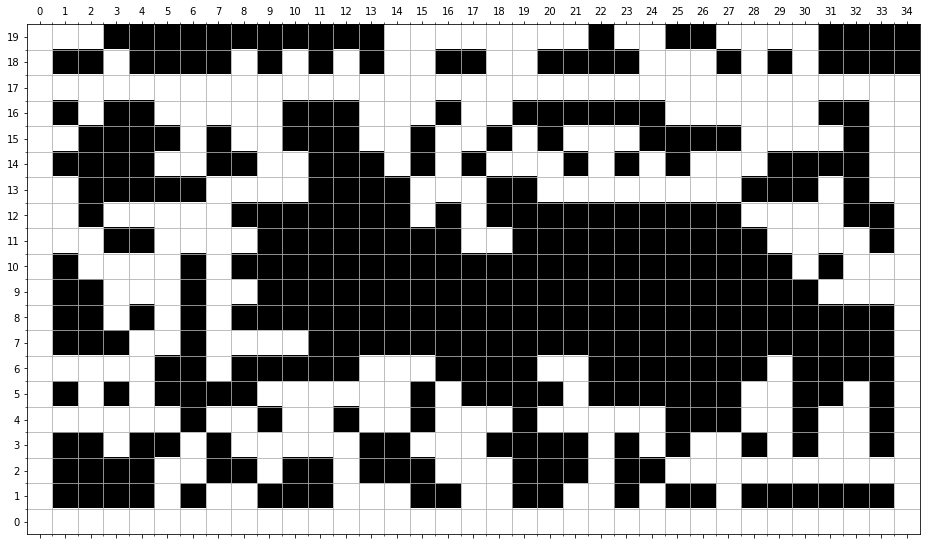

range(0, 35)


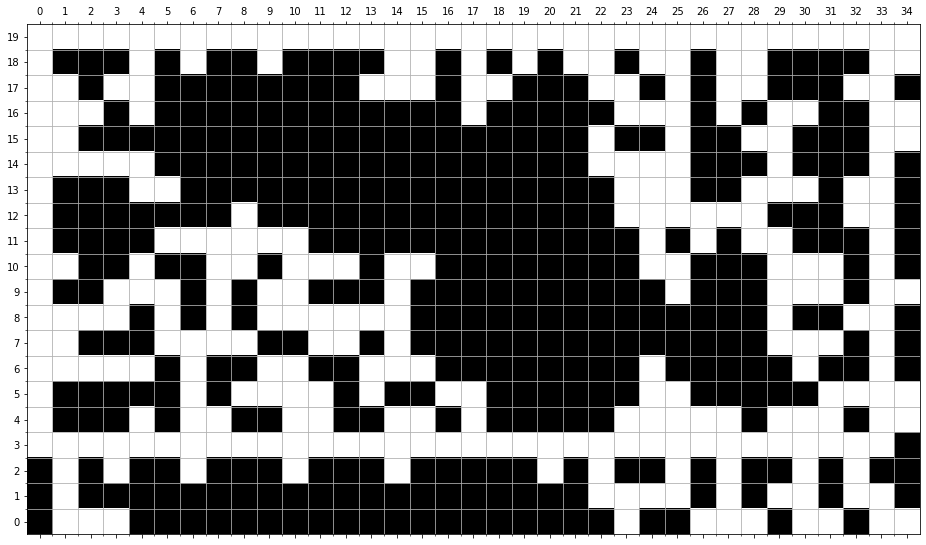

range(0, 35)


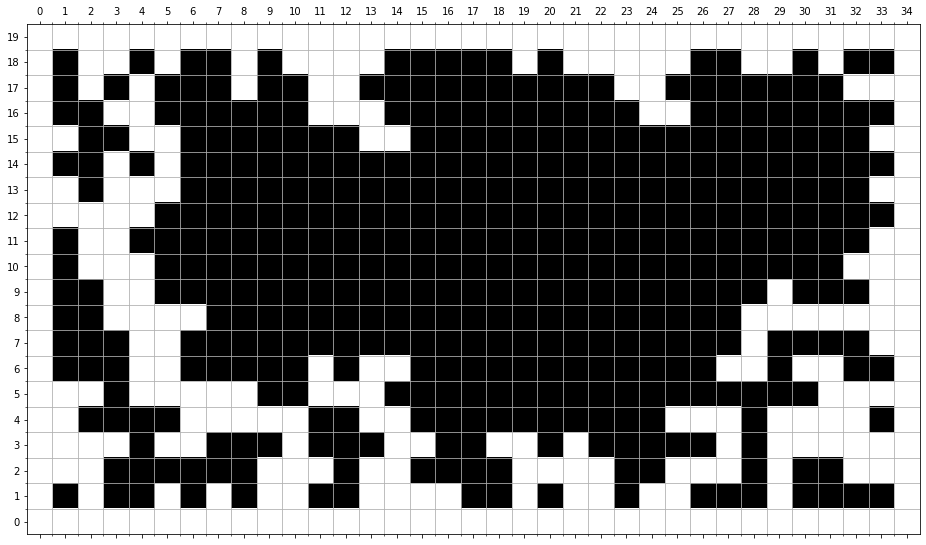

range(0, 35)


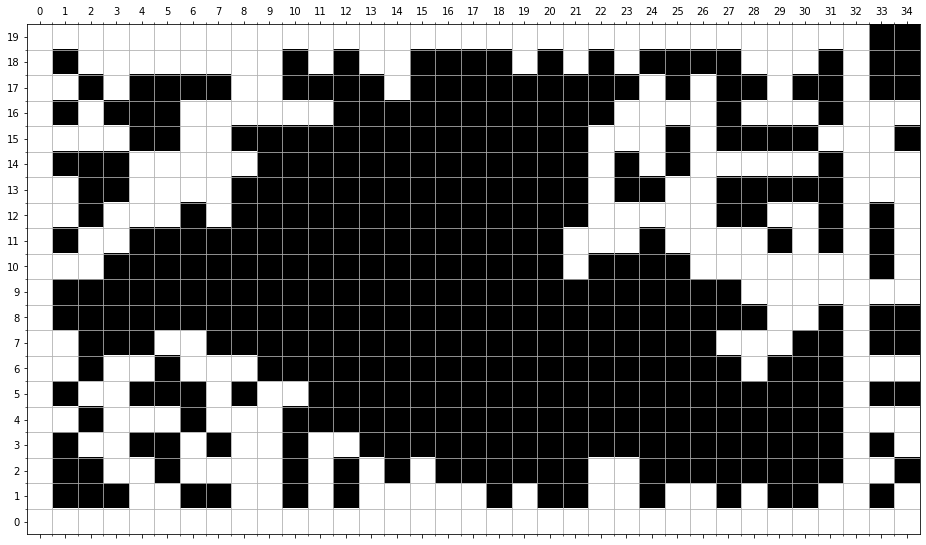

range(0, 35)


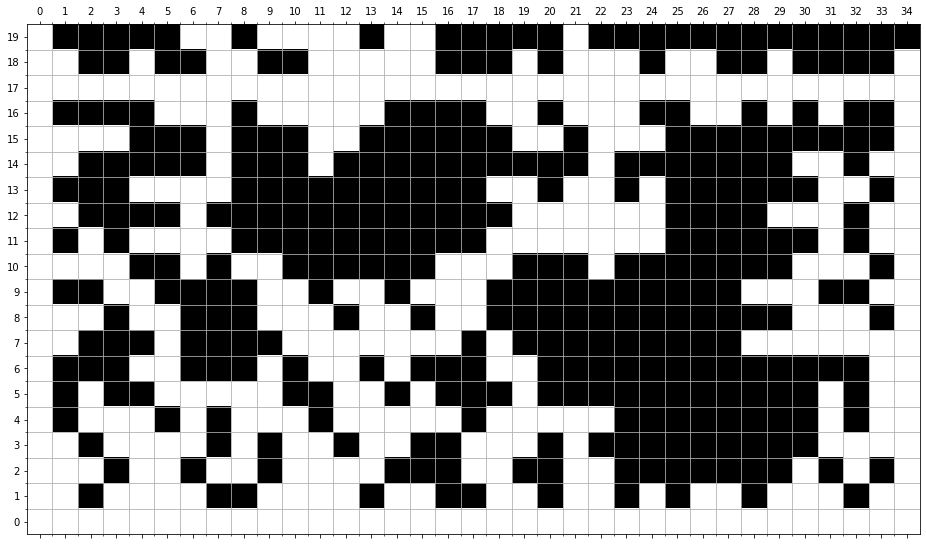

range(0, 35)


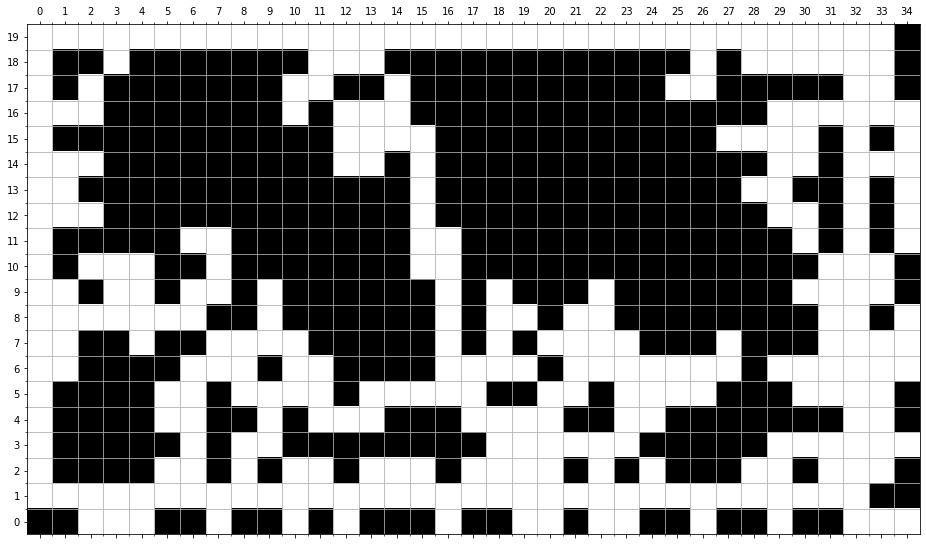

In [40]:
i = 0

from fitness import repair_and_test_map, translate_gene, repair_map

for solution in solutions:
    repaired_map, _ = repair_map(translate_gene(solution['best_map_from_final_gen'].gene, config['fitness_kwargs']['height'], config['fitness_kwargs']['width']))
    plotMap(repaired_map, i)
    i+=1

    

## YELLOW and RED Deliverables
Feel free to create more notebook cells for YELLOW and RED deliverables as necessary. Here are some comments on those deliverables.

### Config Files
For the YELLOW and RED deliverables in this assignment, you are tasked with creating your own config files. For the YELLOW deliverable, for example, you may want to add an additional configuration parameter for how often CIAO evaluations are performed. For many of the RED deliverables, you can use the provided config files and code as inspiration for new config files and the parsing of those files, respectively.

### Modified Fitness Function
RED deliverables 1-3 require a modified version of the `play_GPac` function. See the last cell of `2b_notebook.ipynb` for more information.

In [42]:
#red deliverable 1 code starts here
from random import shuffle
from statistics import mean
def competitive_evaluation_pac_vs_ghost(pac_population, ghost_population, penalty_coefficient, opponentCount = 1, **fitness_kwargs):
    #I know this is a stupid way of assigning matches, but its kind of random, and I don't know how to guarantee everyone plays once with the sample function
    
    matches = []
    shuffle(ghost_population)
    shuffle(pac_population)
    for i in range(opponentCount):
        if(len(ghost_population) < len(pac_population)):
            for ghost_individual_idx in range(len(ghost_population)):
                matches.append({"ghost" : ghost_population[ghost_individual_idx], "Pac" : pac_population[(ghost_individual_idx + i) % len(pac_population)]})
                ghost_population[ghost_individual_idx].fitsFromCompetition = []
                pac_population[pac_individual_idx].rawFitsFromCompetition = []
        else:
            for pac_individual_idx in range(len(pac_population)):
                matches.append({"ghost" : ghost_population[(pac_individual_idx + i)% len(ghost_population)], "Pac" : pac_population[pac_individual_idx]})
                pac_population[pac_individual_idx].fitsFromCompetition = []
                pac_population[pac_individual_idx].rawFitsFromCompetition = []

    # TODO: evaluate matches with play_GPac
    # Hint: play_GPac(pac_controller, ghost_gene, **fitness_kwargs)
    for match in matches:
        match["ghost"].gene.updateChildrenCount(match["ghost"].gene.root)
        match["Pac"].gene.updateChildrenCount(match["Pac"].gene.root)
        fitness, log = play_GPac(match["Pac"].gene, ghost_controller=match['ghost'], **fitness_kwargs)
        #if there are less ghosts than pacs, each ghost will have multiple pacs
        if(len(ghost_population) < len(pac_population)) or opponentCount > 1:
            match["ghost"].rawFitsFromCompetition.append(-fitness)
            match["ghost"].fitsFromCompetition.append(-fitness  - penalty_coefficient * (match["Pac"].gene.root.childrenCount+1))
            if(-fitness == min(match["ghost"].fitsFromCompetition)):
                match["ghost"].log = log
        else:
            match["ghost"].rawFitness = -fitness
            match["ghost"].fitness = -fitness - penalty_coefficient * (match["Pac"].gene.root.childrenCount+1) 
            match["ghost"].log = log
        #if there are more pacs than ghosts each pac will have multiple ghosts
        if(len(ghost_population) > len(pac_population or opponentCount > 1)):
            match["Pac"].rawFitsFromCompetition.append( fitness)
            match["Pac"].fitsFromCompetition.append(fitness - penalty_coefficient * (match["Pac"].gene.root.childrenCount+1))
            if(fitness == max(match['Pac'].rawFitsFromCompetition)):
                match["Pac"].log = log
        else:
            match["Pac"].rawFitness = fitness
            match["Pac"].fitness = match["Pac"].rawFitness - penalty_coefficient * (match["Pac"].gene.root.childrenCount+1)    
            match["Pac"].log = log
    if(len(ghost_population) < len(pac_population) or opponentCount > 1):
        for ghost_individual in ghost_population:
            ghost_individual.fitness = mean(ghost_individual.fitsFromCompetition)
    elif(len(ghost_population) > len(pac_population) or opponentCount > 1):
        for pac_individual in pac_population:
            pac_individual.fitness = mean(pac_individual.fitsFromCompetition)
            pac_individual.rawFitness = mean(pac_individual.fitsFromCompetition)
    # TODO: calculate and assign fitness (don't forget the parsimony penalty)
    pass

In [34]:
import statistics
config = readConfig('./configs/red2c1_config.txt', globalVars=globals(), localVars=locals())
b = binaryGenotype()
treePopulation = treeGenotype.initialization(25, **config['pac_initialization_kwargs'])
ghostPopulation = treeGenotype.initialization(25, **config['ghost_initialization_kwargs'])
competitive_evaluation_pac_vs_ghost(treePopulation, ghostPopulation, **config['fitness_kwargs'])

# inspect fitness assignment
print(f'Trees with unassigned fitness: {len([individual.rawFitness for individual in treePopulation if individual.fitness is None])}')
print(f'ghosts with unassigned fitness: {len([individual.rawFitness for individual in ghostPopulation if individual.fitness is None])}')

# inspect per-species fitness values
print(f'Average fitness of tree population: {statistics.mean([individual.fitness for individual in treePopulation])}')
maxFitness = max([individual.fitness for individual in treePopulation])
print(f'Best fitness in tree population: {maxFitness}')
print(f'Average fitness of ghost population: {statistics.mean([individual.fitness for individual in ghostPopulation])}')
maxFitness = max([individual.fitness for individual in ghostPopulation])
print(f'Best fitness in ghost population: {maxFitness}')

del config
del treePopulation
del ghostPopulation

Trees with unassigned fitness: 0
ghosts with unassigned fitness: 0
Average fitness of tree population: 9.2
Best fitness in tree population: 51.4
Average fitness of ghost population: -22.080000000000002
Best fitness in ghost population: -3.4000000000000004


In [43]:
number_evaluations = 2000
from math import inf

# You can parse different configuration files here as necessary
def competitiveEvolutionPacVsGhost(config, number_evaluations, runNumber):
    pac_config = {key.partition('_')[-1]:config[key] for key in config if "pac_" in key}
    ghost_config = {key.partition('_')[-1]:config[key] for key in config if "ghost_" in key}
    pac_population = geneticProgrammingPopulation(**config['pac_GP_configs'], **pac_config)
    ghost_population = geneticProgrammingPopulation(**config['ghost_GP_configs'], **ghost_config)
    competitive_evaluation_pac_vs_ghost(pac_population.population,ghost_population.population, **config['fitness_kwargs'])
    pac_population.evaluations = len(pac_population.population)
    ghost_population.evaluations = len(ghost_population.population)
    avg_pac_fitnesses = [statistics.mean([individual.rawFitness for individual in pac_population.population])]
    avg_ghost_fitnesses = [statistics.mean([individual.rawFitness for individual in ghost_population.population])]
    max_ghost_fitnesses = [max([individual.fitness for individual in ghost_population.population])]
    max_pac_fitnesses = [max([individual.rawFitness for individual in pac_population.population])]
    evals = max([len(pac_population.population), len(ghost_population.population)])
    evals_at_iteration = [evals]
    while(evals < number_evaluations):
        competitive_evaluation_pac_vs_ghost(pac_population.population,ghost_population.population, **config['fitness_kwargs'])
        pac_children = pac_population.generate_children()
        pac_population.population += pac_children
        ghost_children = ghost_population.generate_children()
        ghost_population.population += ghost_children
        competitive_evaluation_pac_vs_ghost(pac_population.population,ghost_population.population, **config['fitness_kwargs'])
        evals += max([len(ghost_population.population), len(pac_population.population)])
        ghost_population.survival()
        pac_population.survival()
        avg_pac_fitnesses.append(statistics.mean([individual.rawFitness for individual in pac_population.population]))
        avg_ghost_fitnesses.append(statistics.mean([individual.rawFitness for individual in ghost_population.population]))
        max_ghost_fitnesses.append(max([individual.rawFitness for individual in ghost_population.population]))
        max_pac_fitnesses.append(max([individual.rawFitness for individual in pac_population.population]))
        evals_at_iteration.append(evals)
    pac_max_fit = -inf
    ghost_max_fit = -inf
    best_pac = None
    best_ghost = None
    for pac_individual in pac_population.population:
        if(pac_individual.rawFitness > pac_max_fit):
            best_pac = pac_individual
            pac_max_fit = best_pac.rawFitness
    for ghost_individual in ghost_population.population:
        if(ghost_individual.rawFitness > ghost_max_fit):
            best_ghost = ghost_individual
            ghost_max_fit = best_ghost.fitness
    return {"best_pac_from_final_gen" : best_pac, "best_ghost_from_final_gen" : best_ghost, 'avg_ghost_fitnesses': avg_ghost_fitnesses, "avg_pac_fitnesses" : avg_pac_fitnesses, "max_ghost_fitnesses": max_ghost_fitnesses, "max_pac_fitnesses": max_pac_fitnesses, "evals_at_iteration" : evals_at_iteration }
    

In [61]:
config = readConfig('./configs/red2c1_config.txt', globalVars=globals(), localVars=locals())
number_runs = 30
number_evaluations = 2000
from multiprocessing import Pool
from functools import partial
pac_config = {key.partition('_')[-1]:config[key] for key in config if "pac_" in key}
map_config = {key.partition('_')[-1]:config[key] for key in config if "map_" in key}
if __name__ == '__main__':
    p = Pool(number_runs)
    partialEa = partial(competitiveEvolutionPacVsGhost, config, number_evaluations)
    pac_v_ghost_solutions = p.map(partialEa, range(number_runs))
    p.close()
    p.join()
# Implement your 30-run experiment here


In [40]:
with open("data/red1/maxRawPacFitsVGhost.txt", 'w') as f:
    [f.write(str(solution['best_pac_from_final_gen'].rawFitness) + '\n') for solution in pac_v_ghost_solutions]
with open("data/red1/maxRawGhostFitsVPac.txt", 'w') as f:
    [f.write(str(solution['best_ghost_from_final_gen'].rawFitness) + '\n') for solution in pac_v_ghost_solutions]


In [10]:
best_ghost = None
best_pac = None
pac_max_fit = -inf
for pac_v_ghost_solution in pac_v_ghost_solutions:
    if(pac_max_fit < pac_v_ghost_solution["best_pac_from_final_gen"].rawFitness):
        best_pac = pac_v_ghost_solution['best_pac_from_final_gen']
        best_ghost = pac_v_ghost_solution['best_ghost_from_final_gen']
fitness, log = play_GPac(best_pac.gene, ghost_gene = best_ghost.gene, **config['fitness_kwargs'])

game_log_path = 'worldFiles/exhibition_log_ghost_vs_pac.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in log]

In [11]:
treePath = 'solutions/red1/bestPacTreeVGhost.txt'
with open(treePath, 'w') as f:
    f.write(str(best_pac.gene))
treePath = 'solutions/red1/bestGhostTreeVPac.txt'
with open(treePath, 'w') as f:
    f.write(str(best_ghost.gene))

In [13]:
avg_ghost_fits = [solution['avg_ghost_fitnesses'] for solution in pac_v_ghost_solutions]
mean_avg_ghost_fits = list(map(statistics.mean, zip(*avg_ghost_fits)))
max_ghost_fits = [solution['max_ghost_fitnesses'] for solution in pac_v_ghost_solutions]
avg_max_ghost_fits = list(map(statistics.mean, zip(*max_ghost_fits)))

avg_pac_fits = [solution['avg_pac_fitnesses'] for solution in pac_v_ghost_solutions]
mean_avg_pac_fits = list(map(statistics.mean, zip(*avg_pac_fits)))
max_pac_fits = [solution['max_pac_fitnesses'] for solution in pac_v_ghost_solutions]
avg_max_pac_fits = list(map(statistics.mean, zip(*max_pac_fits)))

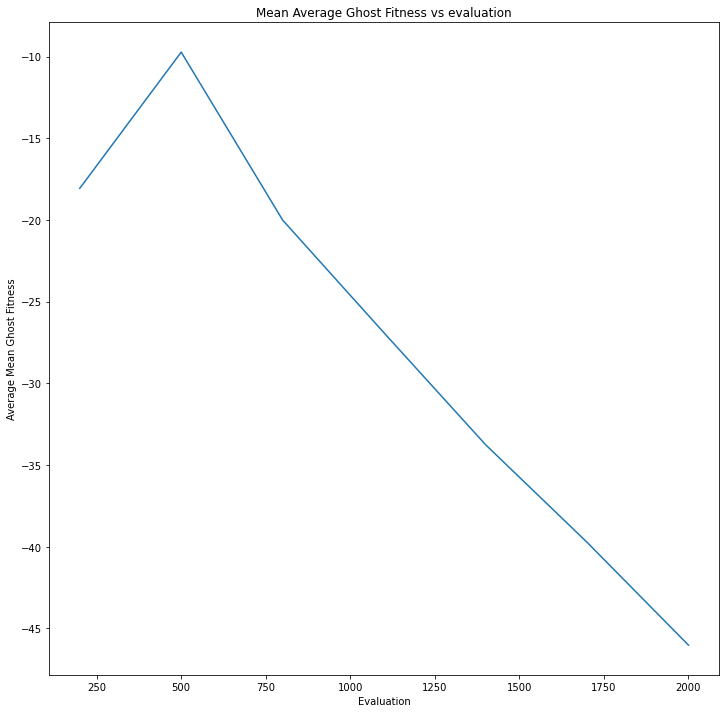

In [29]:
evalList = [evals for evals in solutions[0]['evals_at_iteration']]
plt.plot(evalList, mean_avg_ghost_fits)

plt.title("Mean Average Ghost Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Average Mean Ghost Fitness')
plt.savefig('data/red1/meanAvgGhostFitGraphPacVGhost.jpg')
plt.show()

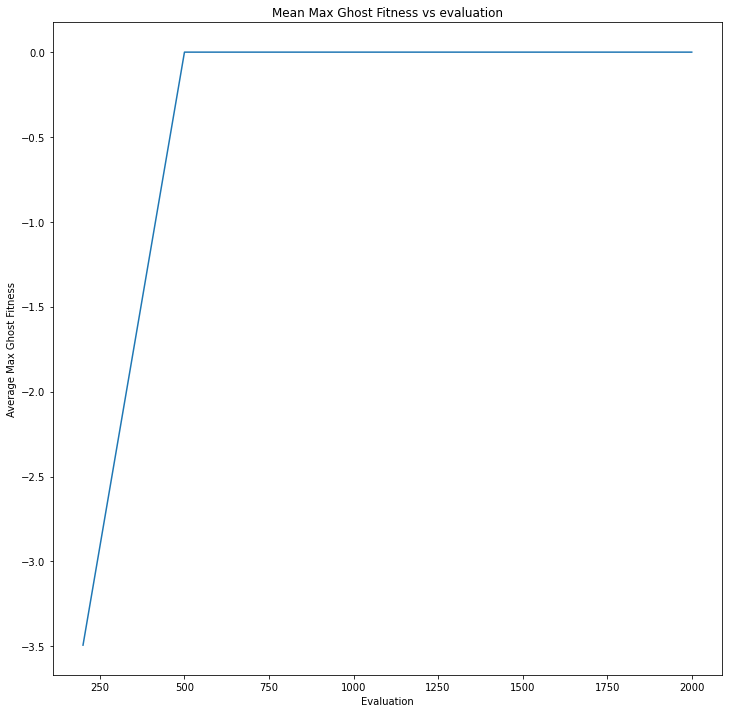

In [30]:
evalList = [evals for evals in solutions[0]['evals_at_iteration']]
plt.plot(evalList, avg_max_ghost_fits)

plt.title("Mean Max Ghost Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Average Max Ghost Fitness')
plt.savefig('data/red1/meanMaxGhostFitGraphPacVGhost.jpg')
plt.show()

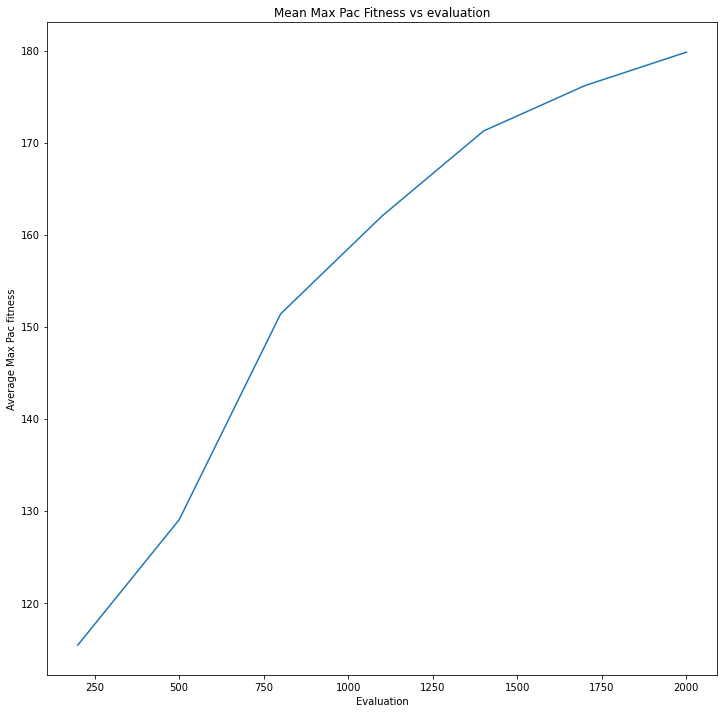

In [28]:
evalList = [evals for evals in solutions[0]['evals_at_iteration']]
plt.plot(evalList, avg_max_pac_fits)

plt.title("Mean Max Pac Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Average Max Pac fitness')
plt.savefig('data/red1/meanMaxPacFitGraphPacVGhost.jpg')
plt.show()

In [62]:
evalList = [evals for evals in solutions[0]['evals_at_iteration']]
plt.plot(evalList, mean_avg_pac_fits)

plt.title("Mean Average Pac Fitness vs evaluation")
plt.xlabel('Evaluation')
plt.ylabel('Average Mean Pac fitness')
plt.savefig('data/red1/meanAvgPacFitGraphPacVGhost.jpg')
plt.show()